# Food Images Classification

## DS-telecom-14 - Applied Deep Learning with Python (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

<p><b>The objective of the project is to identify the name of a food recipe from a photo.</b></p> 
<p>For this, we use a transfer learning method on a pre-trained CNN model whose performance is evaluated with the "accuracy" metric.</p> 
<p>We use the Food-101 dataset available in Kaggle which contains 101000 tagged images of food which are distributed in 101 classes. (<a href= https://www.kaggle.com/kmader/food41>https://www.kaggle.com/kmader/food41</a>). </p>
<p>After testing on Kaggle with GPU several pre-trained models, we chose the one that gives the best accuracy value on the validation data.</p>
<p>After tuning the model, we will be able to complete the dataset of food images with photos from other sites (e.g. marmiton) or personal photos.</p>
<p>In a dedicated notebook, we analyze the results obtained by plotting the classification report and the confusion matrix and by visualizing some images of correctly recognized food and some images not recognized by the model. We try to understand why some images are misclassified.</p>
<p>We also plan to develop a <b>demo web-app</b> to test our best model on new images.
<p>Our project answers <b>two use cases</b>: the model could be used to make focused advertising (restaurant, pastry chef ... ) from the analysis of food images posted on social networks or it could be used in a dedicated application available on smartphone that would give the name and the recipe of a dish from a photo.</p>

## Notebook settings

In [5]:
import os

Models = {}

# Run locally on the laptop or run on Kaggle to take advantage of the GPU
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
    result_dir = '/kaggle/working'
    Models["custom_model"] = "/kaggle/input/models/saved_models/custom_model_v2"
    Models["inceptionV3"] = "/kaggle/input/models/saved_models/inceptionV3_15epochs"
    Models["EfficientNetB0"] = "/kaggle/input/models/saved_models/EfficientNetB0_20epochs"
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    result_dir = 'result_files/'
    Models["custom_model"] = "./saved_models/custom_model_v2"
    Models["inceptionV3"] = "./saved_models/inceptionV3_15epochs"
    Models["EfficientNetB0"] = "./saved_models/EfficientNetB0_20epochs"

print("The models are: {}".format(Models))

Running on localhost
The models are: {'custom_model': './saved_models/custom_model_v2', 'inceptionV3': './saved_models/inceptionV3_15epochs', 'EfficientNetB0': './saved_models/EfficientNetB0_20epochs'}


## Libraries

In [6]:
import sys 
print("Python version: {}". format(sys.version))

import random

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
print("sklearn version: {}". format(sklearn.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("tensorflow version : {}". format(tf.__version__))
print("================================")

Python version: 3.9.2 (v3.9.2:1a79785e3e, Feb 19 2021, 09:06:10) 
[Clang 6.0 (clang-600.0.57)]
IPython version: 7.20.0
NumPy version: 1.21.5
SciPy version: 1.7.3
pandas version: 1.3.5
sklearn version: 1.0.2
matplotlib version: 3.5.1
seaborn version : 0.11.2
tensorflow version : 2.7.0


## Utility functions

In [7]:
def get_result_pred(model, model_name, val_data, data_dir, img_height, img_width):

    class_dict=val_data.class_indices
    labels= val_data.labels
    file_names= val_data.filenames 
    to_print = max(int(len(file_names) / 100), 10)
    
    new_dict = {}
    dict_result = {}
    dict_result["image"] = []
    dict_result["True_class"] = []
    dict_result["Predict_class"] = []
    for key in class_dict.keys():
        dict_result[key] = []
    dict_result["True_index"] = []
    dict_result["Predict_index"] = []
    dict_result["Result_OK"] = []
    
    
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}

    print("Processing in progress ", end="")

    for i, fichier in enumerate(file_names):
        if (i % to_print) == 0:
            print('.', end="")
        dict_result["image"].append(fichier)
        dict_result["True_index"].append(labels[i])  # labels are integer values
        dict_result["True_class"].append(new_dict[labels[i]])
        
        image_file = os.path.join(data_dir, fichier)
        img = tf.keras.utils.load_img(image_file, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = img_array / 255.
        img_array = tf.expand_dims(img_array, 0) # Create a batch    
        predictions = model.predict(img_array)
        score = predictions[0]
        
        for j, valeur in enumerate(score):
            dict_result[new_dict[j]].append(valeur)

        pred_index=np.argmax(score)
        dict_result["Predict_index"].append(pred_index)
        dict_result["Predict_class"].append(new_dict[pred_index])

        Result_OK = (pred_index == labels[i] )
        dict_result["Result_OK"].append(Result_OK)

    df_result = pd.DataFrame(dict_result)

    # Saving the dataframe to disk (csv format)
    csv_file_name = "result_{}.csv".format(model_name)
    result_file = os.path.join(result_dir, csv_file_name)
    df_result.to_csv(result_file, sep=';', decimal=',')

    return df_result

In [8]:
def print_info(df_result):
        
    # Nb of errors by classes
    condition_1 = df_result["Result_OK"] == False
    df_erreurs = df_result[condition_1]
    df_nb_error_by_class = pd.DataFrame(df_erreurs["True_class"].value_counts())
    df_nb_error_by_class.sort_values(by="True_class", ascending=True, inplace=True)
    ax = df_nb_error_by_class.plot.barh(color="blue",
                                        figsize=(10, df_nb_error_by_class.shape[0] / 3),
                                        title="Errors by Class on Test Set",
                                        legend=None)
   
    # create a confusion matrix and a classification report
    df_classes = df_result[["True_class", "True_index"]].drop_duplicates()
    df_classes.sort_values(by="True_index", ascending=True, inplace=True)
    classes = df_classes["True_class"].values.tolist()
    indices = df_classes["True_index"].values.tolist()
    
    cm = confusion_matrix(df_result["True_index"], df_result["Predict_index"])
    clr = classification_report(df_result["True_index"], df_result["Predict_index"], target_names=classes)
    
    length=len(classes)

    plt.figure(figsize =(30,30))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='coolwarm', cbar=False)
    plt.xticks(np.arange(length)+.5, label = indices, rotation= 90)
    plt.yticks(np.arange(length)+.5, label = indices, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

In [9]:
def find_missclassified(model, val_data, max_missclassified=9):
    missclassified = []
    max_batch = len(val_data)
    for batch in range(max_batch):
        for img_id in range(batch_size):
            img   = np.expand_dims(val_data[batch][0][img_id], axis=0)
            true_label = class_names[val_data[batch][1][img_id].argmax()]
            pred_vect = model.predict(img).flatten()
            
            pred_label = class_names[pred_vect.argmax()]
            proba = round(pred_vect.max() * 100, 3) 
            if true_label != pred_label:
                missclassified.append({'true_label' : true_label, 
                                       'pred_label' : pred_label, 
                                       'proba'      : proba, 
                                       'img'        : img[0]
                                    })

            if len(missclassified) >= max_missclassified:
                return missclassified

    return missclassified

def plot_missclassified(missclassified):
    if len(missclassified) != 9:
        print("Bad length for missclassified, should be 9")
        print("actual length : ", len(missclassified))
    else:
        plt.figure(figsize=(10, 10))
        for i in range(len(missclassified)):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(missclassified[i]['img'])
            title = 'True : ' + missclassified[i]['true_label'] + \
                    '\n Predicted : ' + missclassified[i]['pred_label']
            plt.title(title)
            plt.axis("off")
        
        plt.show()

In [25]:
def plot_one_prediction(img, model, class_names, label=None, rescale_input=False):
    plt.imshow(img)
    plt.grid(False)
    plt.show()
    img = np.expand_dims(img, axis=0)
    
    if rescale_input:
       img = img / 255.

    pred_vect = model.predict(img)

    pred_idx_sorted  = np.argsort(pred_vect).flatten()
    proba_sorted     = np.sort(pred_vect).flatten()

    if label is not None:
        print("True label : ",class_names[label.argmax()])

    for i in range(1, 5):
        print(" --> ", class_names[pred_idx_sorted[-i]]," predicted with proba " ,round(proba_sorted[-i] * 100, 3), "%")
        
    print("---------------------------------------------")

# Inception V3

In [11]:
batch_size = 32

img_height = 224
img_width = 224

In [12]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [13]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [14]:
class_dict  = train_data.class_indices
class_names = []
for cat in class_dict.keys():
    class_names.append(cat)
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [15]:
inceptionV3 = keras.models.load_model(Models["inceptionV3"])

### Some prediction samples

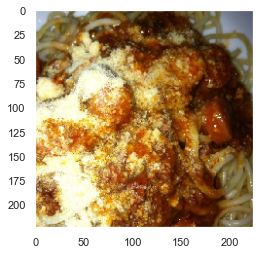

True label :  spaghetti_bolognese
 -->  spaghetti_bolognese  predicted with proba  99.732 %
 -->  spaghetti_carbonara  predicted with proba  0.131 %
 -->  pad_thai  predicted with proba  0.098 %
 -->  lasagna  predicted with proba  0.006 %
---------------------------------------------


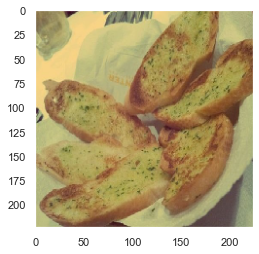

True label :  garlic_bread
 -->  garlic_bread  predicted with proba  99.998 %
 -->  bruschetta  predicted with proba  0.002 %
 -->  escargots  predicted with proba  0.0 %
 -->  foie_gras  predicted with proba  0.0 %
---------------------------------------------


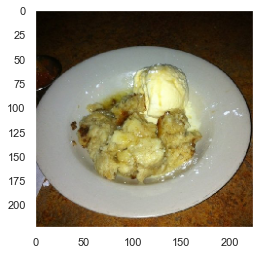

True label :  bread_pudding
 -->  bread_pudding  predicted with proba  93.934 %
 -->  apple_pie  predicted with proba  4.91 %
 -->  baklava  predicted with proba  0.296 %
 -->  strawberry_shortcake  predicted with proba  0.249 %
---------------------------------------------


In [26]:
for _ in range(3):
    random_batch = random.randint(0, len(val_data) - 1)
    random_img = random.randint(0, batch_size - 1)

    img_test = val_data[random_batch][0][random_img]
    label    = val_data[random_batch][1][random_img]
    plot_one_prediction(img_test, inceptionV3, class_names, label=label)

### Some missclassified samples

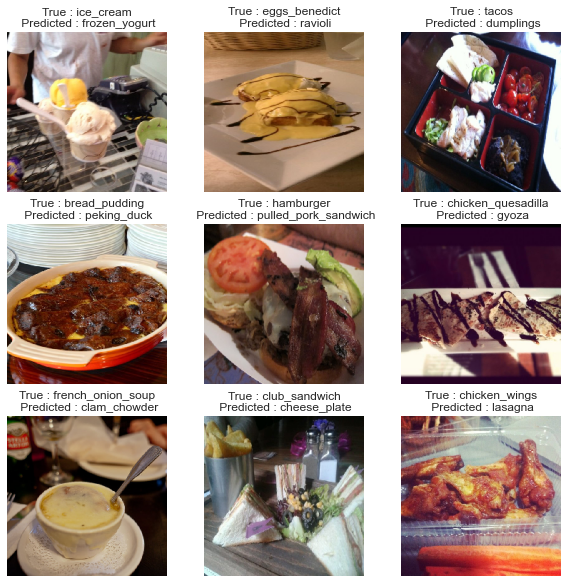

In [28]:
missclassified = find_missclassified(inceptionV3, val_data)
plot_missclassified(missclassified)

### Deeper analysis

In [17]:
try :
    df_inceptionV3 = pd.read_csv(result_dir + 'result_inceptionV3.csv', sep=";", index_col=0)
except:
    df_inceptionV3 = get_result_pred(inceptionV3, "inceptionV3", val_data, data_dir, img_height, img_width)

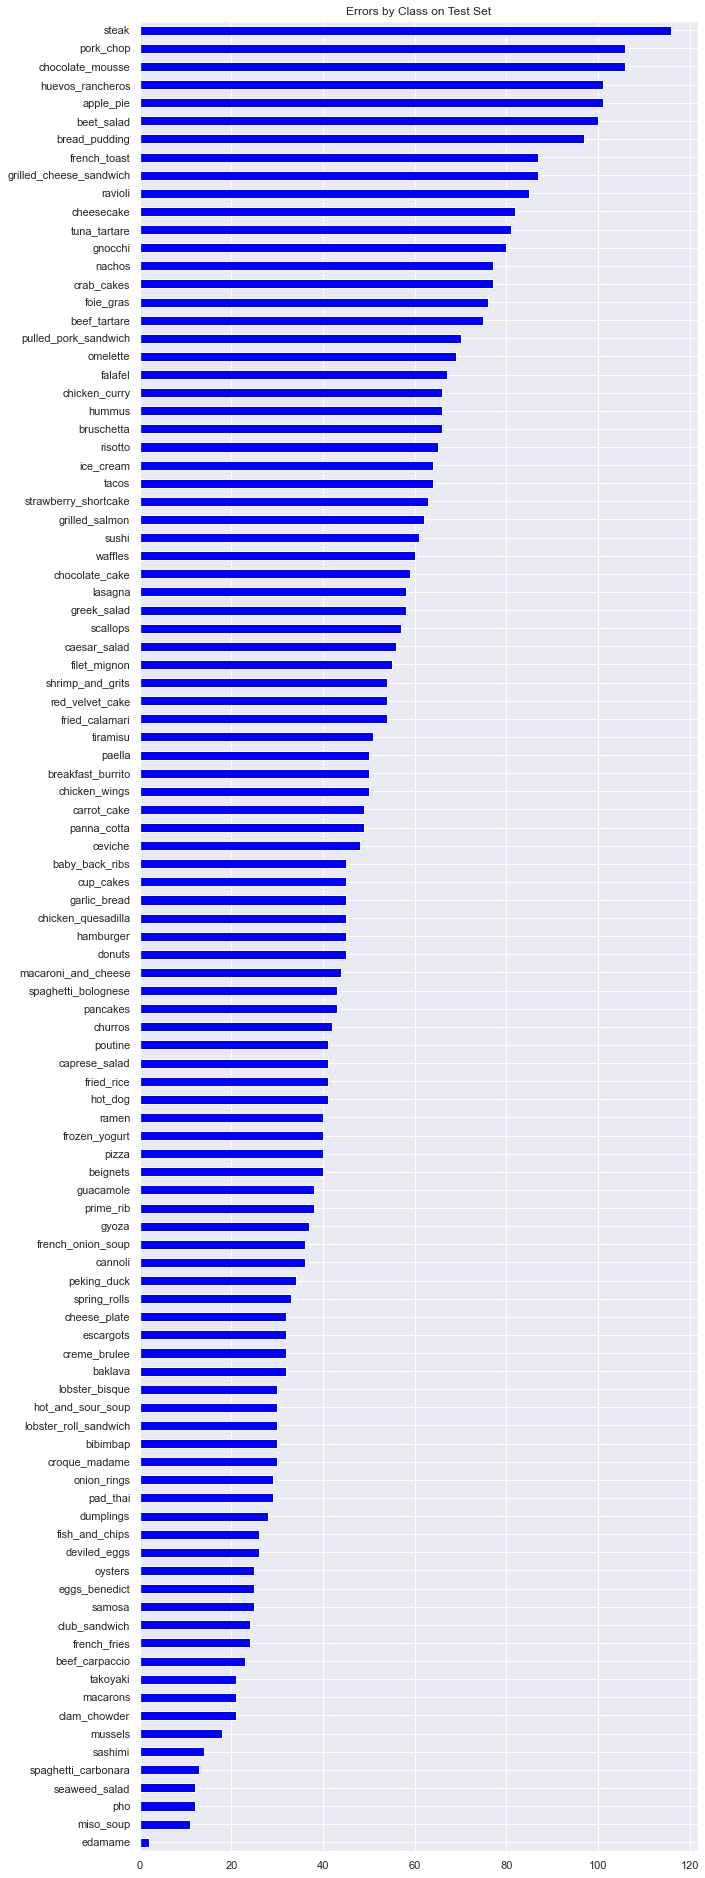

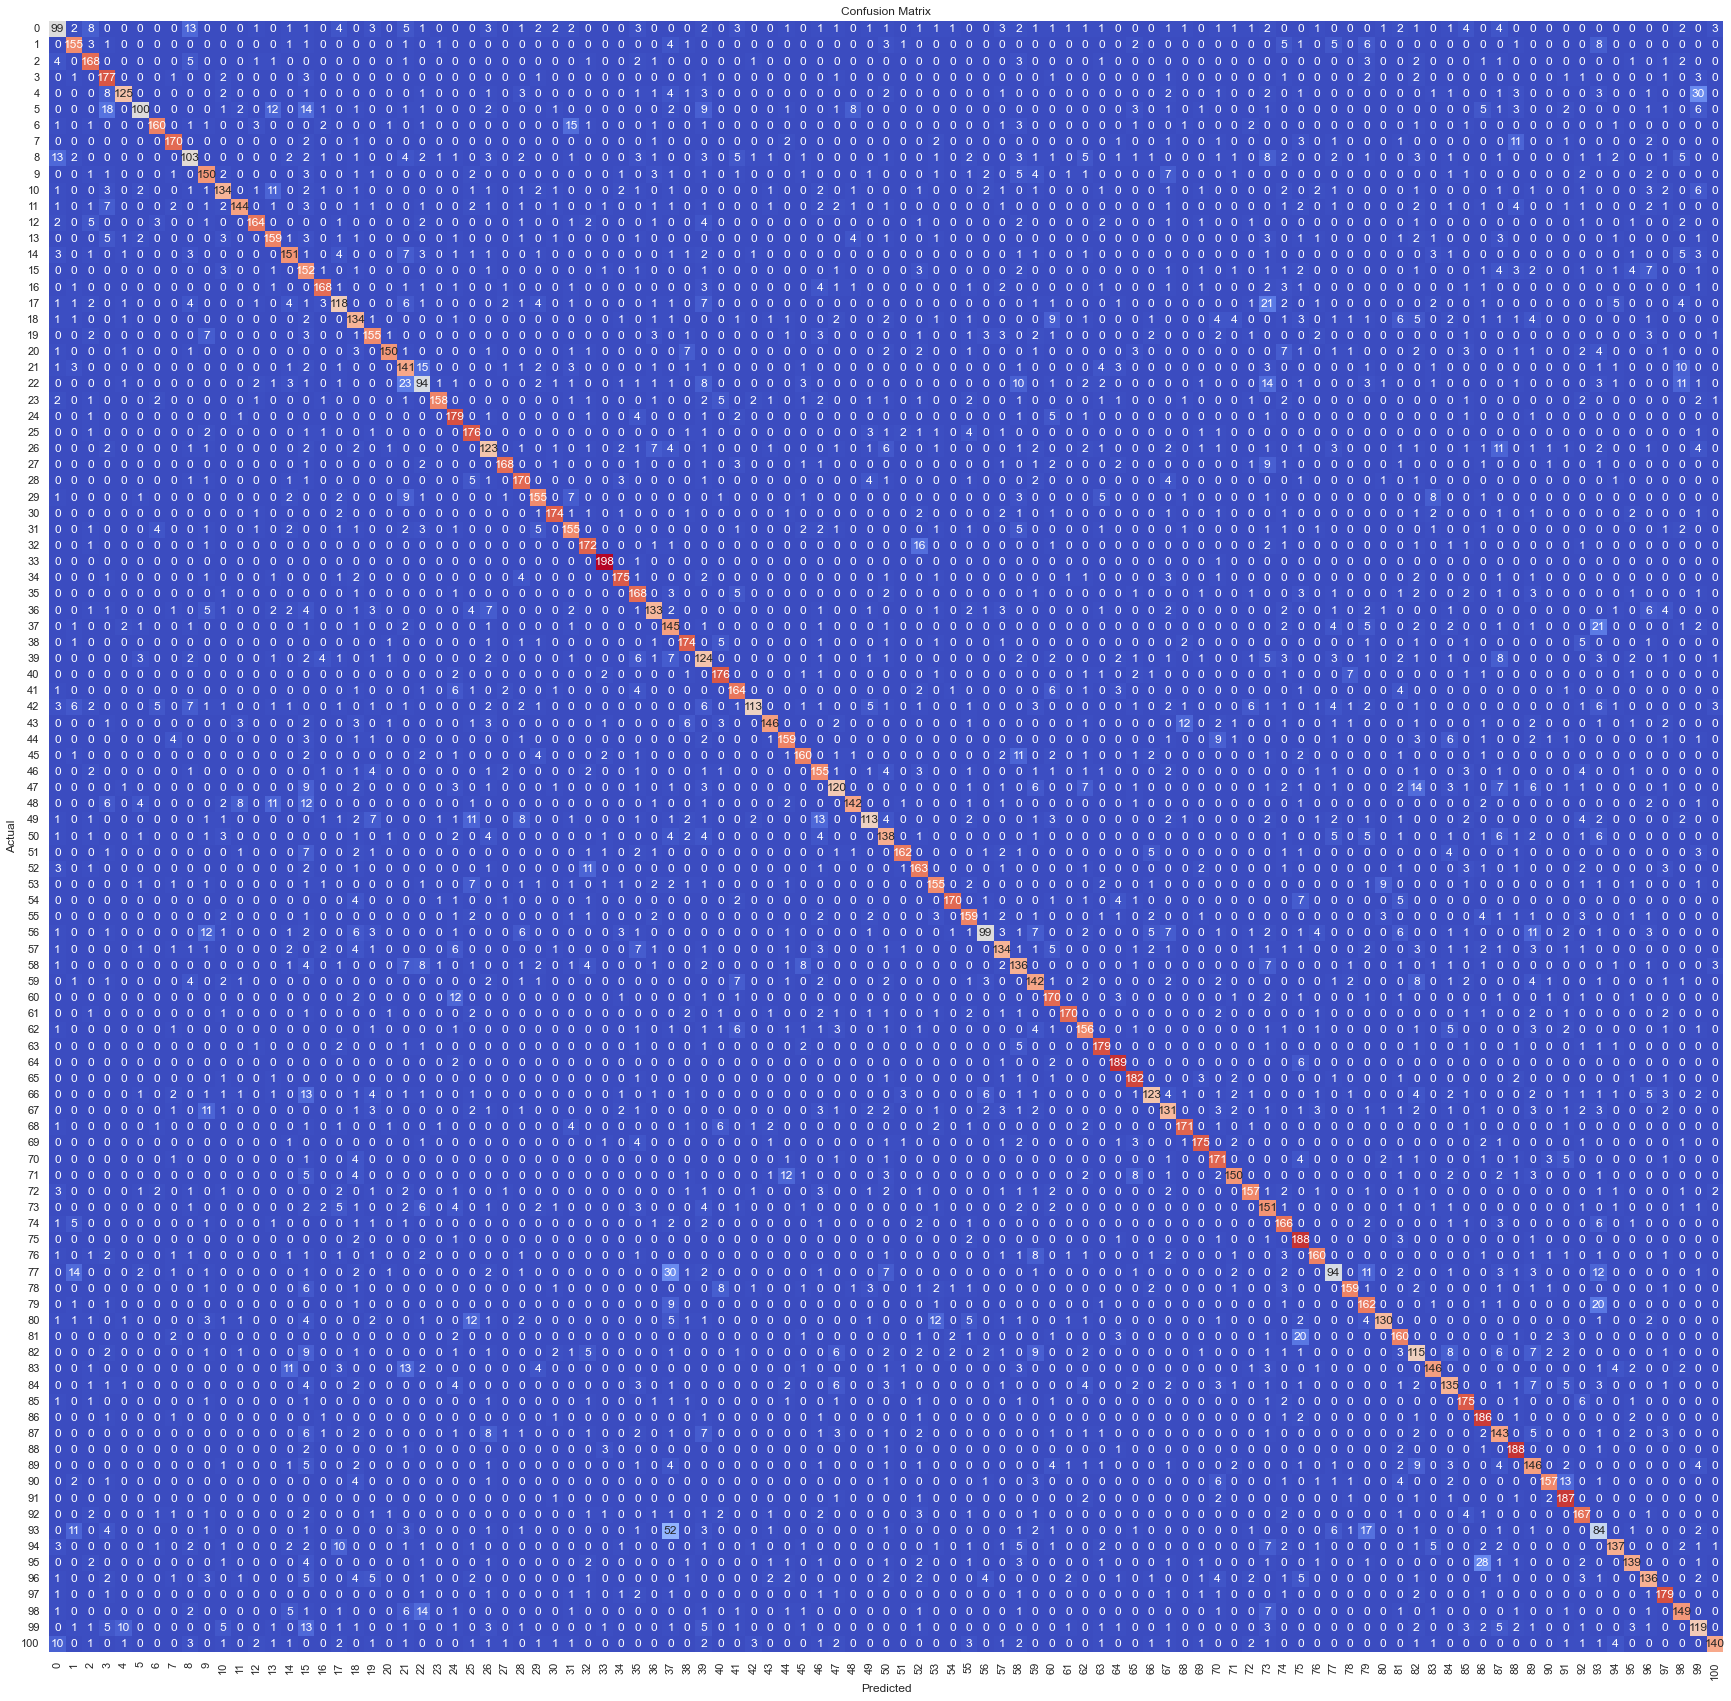

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.59      0.49      0.54       200
         baby_back_ribs       0.73      0.78      0.75       200
                baklava       0.77      0.84      0.81       200
         beef_carpaccio       0.70      0.89      0.78       200
           beef_tartare       0.85      0.62      0.72       200
             beet_salad       0.83      0.50      0.62       200
               beignets       0.89      0.80      0.84       200
               bibimbap       0.88      0.85      0.87       200
          bread_pudding       0.65      0.52      0.57       200
      breakfast_burrito       0.70      0.75      0.72       200
             bruschetta       0.75      0.67      0.71       200
           caesar_salad       0.88      0.72      0.79       200
                cannoli       0.92      0.82      0.87       200
          caprese_salad       0.76      0.

In [18]:
print_info(df_inceptionV3)